# Introduction

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb

Set display options for better visibility

In [4]:
pd.set_option('display.max_columns', None)

Load datasets

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [6]:
print("Training Data Shape:", train_df.shape)
print("\nFirst few rows of training data:")
print(train_df.head())

Training Data Shape: (58645, 13)

First few rows of training data:
   id  person_age  person_income person_home_ownership  person_emp_length  \
0   0          37          35000                  RENT                0.0   
1   1          22          56000                   OWN                6.0   
2   2          29          28800                   OWN                8.0   
3   3          30          70000                  RENT               14.0   
4   4          22          60000                  RENT                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income  \
0   EDUCATION          B       6000          11.49                 0.17   
1     MEDICAL          C       4000          13.35                 0.07   
2    PERSONAL          A       6000           8.90                 0.21   
3     VENTURE          B      12000          11.11                 0.17   
4     MEDICAL          A       6000           6.92                 0.10   

  cb_person_default

In [7]:
print("\nDataset Info:")
print(train_df.info())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), i

In [9]:
print("\nBasic statistics of numerical columns:")
print(train_df.describe())


Basic statistics of numerical columns:
                 id    person_age  person_income  person_emp_length  \
count  58645.000000  58645.000000   5.864500e+04       58645.000000   
mean   29322.000000     27.550857   6.404617e+04           4.701015   
std    16929.497605      6.033216   3.793111e+04           3.959784   
min        0.000000     20.000000   4.200000e+03           0.000000   
25%    14661.000000     23.000000   4.200000e+04           2.000000   
50%    29322.000000     26.000000   5.800000e+04           4.000000   
75%    43983.000000     30.000000   7.560000e+04           7.000000   
max    58644.000000    123.000000   1.900000e+06         123.000000   

          loan_amnt  loan_int_rate  loan_percent_income  \
count  58645.000000   58645.000000         58645.000000   
mean    9217.556518      10.677874             0.159238   
std     5563.807384       3.034697             0.091692   
min      500.000000       5.420000             0.000000   
25%     5000.000000      

In [10]:
print("Target Variable Distribution:")
print(train_df['loan_status'].value_counts(normalize=True) * 100)

Target Variable Distribution:
loan_status
0    85.761787
1    14.238213
Name: proportion, dtype: float64


In [11]:

# Categorical variables
print("\nUnique values in categorical columns:")
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
for col in categorical_cols:
    print(f"\n{col}:")
    print(train_df[col].value_counts())


Unique values in categorical columns:

person_home_ownership:
person_home_ownership
RENT        30594
MORTGAGE    24824
OWN          3138
OTHER          89
Name: count, dtype: int64

loan_intent:
loan_intent
EDUCATION            12271
MEDICAL              10934
PERSONAL             10016
VENTURE              10011
DEBTCONSOLIDATION     9133
HOMEIMPROVEMENT       6280
Name: count, dtype: int64

loan_grade:
loan_grade
A    20984
B    20400
C    11036
D     5034
E     1009
F      149
G       33
Name: count, dtype: int64

cb_person_default_on_file:
cb_person_default_on_file
N    49943
Y     8702
Name: count, dtype: int64


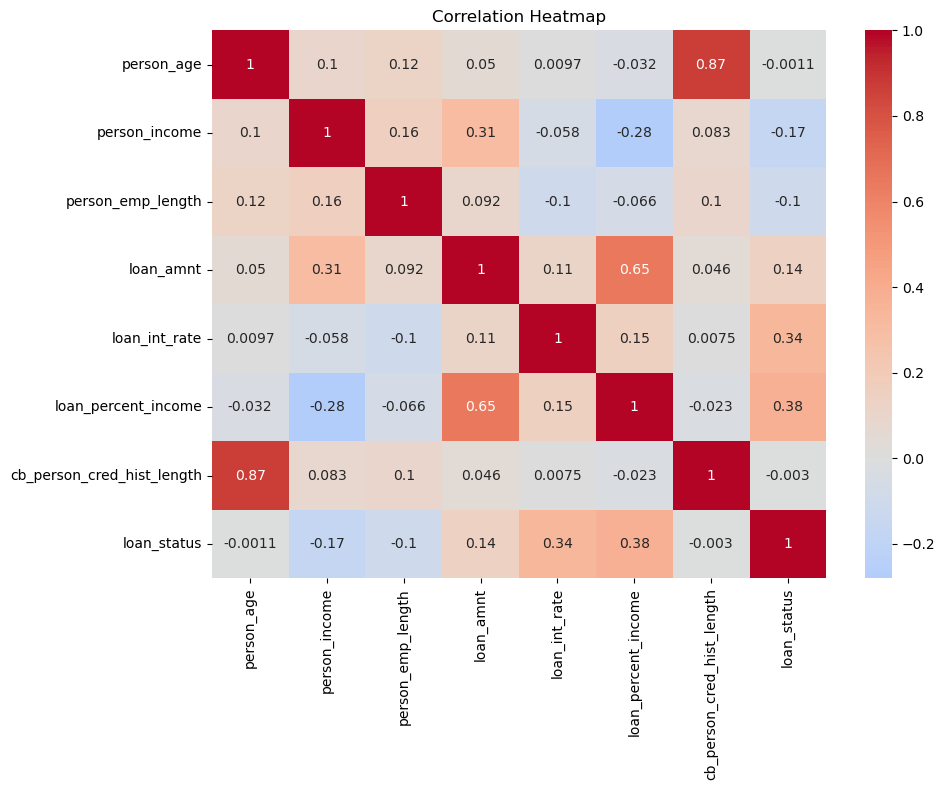

In [12]:
# Correlation heatmap for numerical variables
plt.figure(figsize=(10, 8))
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status']
sns.heatmap(train_df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [13]:
print("\nBasic statistics of loan amount and interest rate:")
print(train_df[['loan_amnt', 'loan_int_rate']].describe())


Basic statistics of loan amount and interest rate:
          loan_amnt  loan_int_rate
count  58645.000000   58645.000000
mean    9217.556518      10.677874
std     5563.807384       3.034697
min      500.000000       5.420000
25%     5000.000000       7.880000
50%     8000.000000      10.750000
75%    12000.000000      12.990000
max    35000.000000      23.220000


            Count  Percentage  Default Rate
loan_grade                                 
A           20984   35.781397      4.918033
B           20400   34.785574     10.230392
C           11036   18.818314     13.537514
D            5034    8.583852     59.356377
E            1009    1.720522     62.537166
F             149    0.254071     61.073826
G              33    0.056271     81.818182


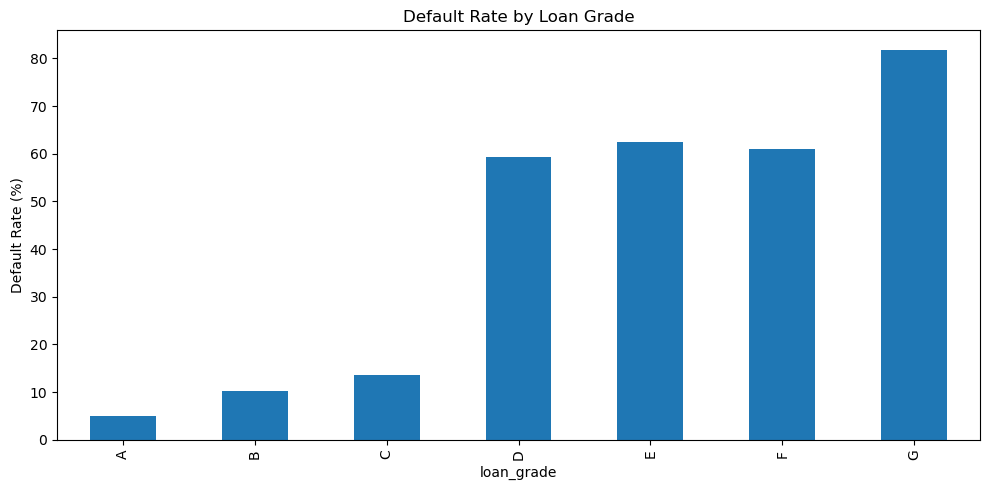

In [20]:
loan_grade_distribution = pd.DataFrame({
    'Count': train_df['loan_grade'].value_counts().sort_index(),
    'Percentage': train_df['loan_grade'].value_counts(normalize=True).sort_index() * 100,
    'Default Rate': train_df.groupby('loan_grade')['loan_status'].mean() * 100
})

print(loan_grade_distribution)

# Visualize it
plt.figure(figsize=(10, 5))
loan_grade_distribution['Default Rate'].plot(kind='bar')
plt.title('Default Rate by Loan Grade')
plt.ylabel('Default Rate (%)')
plt.tight_layout()
plt.show()



Default Rate by Loan Grade:
loan_grade
A     4.918033
B    10.230392
C    13.537514
D    59.356377
E    62.537166
F    61.073826
G    81.818182
Name: loan_status, dtype: float64


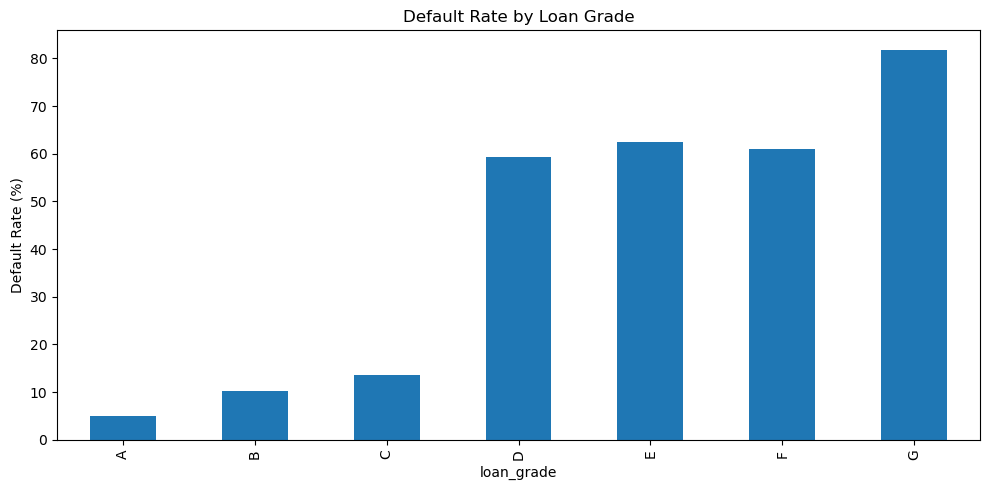

In [25]:
# Preprocess data
X = train_df.copy()

# Drop highly correlated feature
X = X.drop('cb_person_cred_hist_length', axis=1)
    
# Create label encoders for categorical variables
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']
label_encoders = {}
    
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])
    
# Create feature for debt-to-income ratio
X['debt_to_income'] = X['loan_amnt'] / X['person_income']
    
# Standardize numerical columns
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 
                    'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                    'debt_to_income']
    
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
# Separate features and target for training data
y = X['loan_status']
X = X.drop(['loan_status', 'id'], axis=1)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (46916, 11)
Validation set shape: (11729, 11)


[0]	train-auc:0.89720	train-logloss:0.64360	eval-auc:0.89288	eval-logloss:0.64356
[1]	train-auc:0.90453	train-logloss:0.59952	eval-auc:0.90114	eval-logloss:0.59943
[2]	train-auc:0.91309	train-logloss:0.56245	eval-auc:0.91075	eval-logloss:0.56239
[3]	train-auc:0.91227	train-logloss:0.53061	eval-auc:0.91057	eval-logloss:0.53070
[4]	train-auc:0.91410	train-logloss:0.50399	eval-auc:0.91172	eval-logloss:0.50425
[5]	train-auc:0.91560	train-logloss:0.48215	eval-auc:0.91388	eval-logloss:0.48248
[6]	train-auc:0.91867	train-logloss:0.46379	eval-auc:0.91606	eval-logloss:0.46413
[7]	train-auc:0.92057	train-logloss:0.44665	eval-auc:0.91742	eval-logloss:0.44722
[8]	train-auc:0.92153	train-logloss:0.43062	eval-auc:0.91869	eval-logloss:0.43115
[9]	train-auc:0.92205	train-logloss:0.41705	eval-auc:0.91946	eval-logloss:0.41744
[10]	train-auc:0.92312	train-logloss:0.40852	eval-auc:0.92082	eval-logloss:0.40896
[11]	train-auc:0.92312	train-logloss:0.39680	eval-auc:0.92094	eval-logloss:0.39723
[12]	train-auc

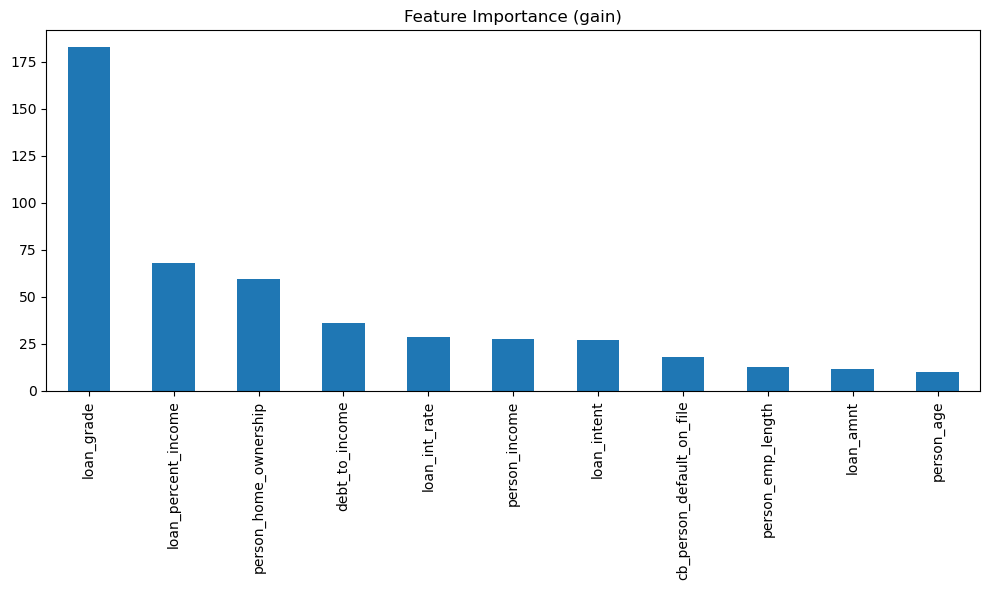

In [34]:
# Calculate scale_pos_weight - (number of negative examples)/(number of positive examples)
negative_samples = (y_train == 0).sum()
positive_samples = (y_train == 1).sum()
scale_pos_weight = negative_samples/positive_samples

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=4,
    min_child_weight=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric=['auc', 'logloss'],
    early_stopping_rounds=20
)

# Convert to DMatrix format for more control
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val, y_val)

# Set parameters
params = xgb_model.get_xgb_params()

# Train with early stopping
eval_results = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'eval')],
    early_stopping_rounds=20,
    evals_result=eval_results,
    verbose_eval=True
)

print("\nBest iteration:", bst.best_iteration)

# Make predictions using the best model
y_pred = (bst.predict(dval) > 0.5).astype(int)
y_pred_proba = bst.predict(dval)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Print AUC-ROC score
print("\nAUC-ROC Score:", roc_auc_score(y_val, y_pred_proba))

# Plot feature importance
importance_type = 'gain'  # can also use 'weight', 'cover', 'total_gain', 'total_cover'
importance = bst.get_score(importance_type=importance_type)
importance_df = pd.DataFrame([importance]).T
importance_df.columns = ['importance']
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
importance_df['importance'].plot(kind='bar')
plt.title(f'Feature Importance ({importance_type})')
plt.tight_layout()
plt.show()